# Speed up CUDA and how to avoid OOM (out of memory) methods

В данном ноутбуке рассмотрим примеры использования следующих методов:
- `torch.cuda.amp.autocast()` (`torch.cpu.amp.autocast()` для `cpu`) для  автоматического усечения градиентов (на базе [статьи](https://wandb.ai/wandb_fc/tips/reports/How-to-use-Autocast-in-PyTorch--VmlldzoyMTk4NTky))
- `torch.cuda.amp.GradScaler` в Pytorch для автоматического масштабирования градиентов (на базе [статьи](https://wandb.ai/wandb_fc/tips/reports/How-to-Use-GradScaler-in-PyTorch--VmlldzoyMTY5MDA5))

## How to use Autocast in PyTorch

В данном разделе мы рассмотрим то, как использовать `torch.cuda.amp.autocast()` (`torch.cpu.amp.autocast()` для `cpu`) - средство для автоматического усечения градиентов во время обучения.

При этом важно отметить, что в более поздних версиях PyTorch можно использовать другую запись:

`torch.autocast(device_type="cuda")` $\equiv$ `torch.cuda.amp.autocast()`

`torch.autocast(device_type="cpu")` $\equiv$ `torch.cpu.amp.autocast()`


Классический `training loop` представлен ниже:

```python
optimizer = ...


for epoch in range(...):
    for i, sample in enumerate(dataloader):
        inputs, labels = sample
        optimizer.zero_grad()


        # Forward Pass
        outputs = model(inputs)
        
        # Compute Loss and Perform Back-propagation
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Update Optimizer
        optimizer.step()
```

И если вы тренировали большие модели, особенно большие языковые модели, вы вероятно сталкивались со следующей ошибкой:

```text
RuntimeError: CUDA out of memory. Tried to allocate .. MiB (.. GiB total capacity; ... GiB already allocated; 
... MiB free; ... GiB reserved in total by PyTorch)
```

OOM - out of memory

Причина ООМ - переполнение памяти. По умолчанию PyTorch использует `float32` для весов модели. Это 32 бита или 4 байта. В больших языковых моделях (например BERT large) количество параметров достигает 32 млн. Т.е. **32 млн. $\times$ 4 байта = 128 Гб**, что по сути является достаточно большой цифрой.

Одно из решений - **автоматически усекать градиенты, чтобы они занимали меньше памяти, например усечь до float16**. Сделать в PyTorch это можно немного изменив код.

```python
optimizer = ...


for epoch in range(...):
    for i, sample in enumerate(dataloader):
        inputs, labels = sample
        optimizer.zero_grad()


        # ⭐️ ⭐️ Autocasting
        with torch.cuda.amp.autocast():
            # Forward Pass
            outputs = model(inputs)
            
            # Compute Loss
            loss = loss_fn(outputs, labels)
        
        # Perform Back-propagation
        loss.backward()
        
        # Update Optimizer
        optimizer.step()
```

## How to use GradScaler in PyTorch

В данном разделе мы рассмотрим то, как использовать инструмент `torch.cuda.amp.GradScaler` для автоматического масштабирования градиентов. Данный метод позволяет повысить эффективность `training loop`, особенно в случае использования `torch.autocast`. Последний усекает градиенты до `float16`, к примеру, и по этой причине градиенты, которые близки к 0, преврящаются в 0 (недостаточно знаков после запятой). Градиенты могут "затухнуть", особенно в глубоких сетях, и обучение сети не будет столь эффективным, как хотелось бы.

**`torch.cuda.amp.GradScaler` позволяет автоматически масштабировать градиенты, "умножая" их на некоторый коэффициент, таким образом препятствую затуханию градиентов при использовании `torch.autocast`, к примеру.**

Классический `training loop` представлен ниже:

```python
optimizer = ...


for epoch in range(...):
    for i, sample in enumerate(dataloader):
        inputs, labels = sample
        optimizer.zero_grad()


        # Forward Pass
        outputs = model(inputs)
        
        # Compute Loss and Perform Back-propagation
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Update Optimizer
        optimizer.step()
```

`training loop` с использованием `GradScaler`

```python
scaler = torch.cuda.amp.GradScaler()
optimizer = .﻿.﻿.
﻿
for epoch in range﻿(﻿.﻿.﻿.﻿)﻿:
    for i, sample in enumerate﻿(dataloader)﻿:
        inputs, labels = sample
        optimizer.zero_grad(﻿)
﻿
        # Forward Pass
        outputs = model(inputs)
        
        # Compute Loss and Perform Back-propagation
        loss = loss_fn(outputs, labels)
	
        # ⭐️ ⭐️ Scale Gradients
        scaler.scale(loss).backward()
        
        # ⭐️ ⭐️ Update Optimizer
        scaler.step(optimizer)
        scaler.update()
```

По сути, `GradScaler` умножает `loss` на коэффициент и выполняет backward pass, при котором градиенты также масштабированы (чтобы градиенты не обнулились). При шаге в сторону антиградиента (обновлении весов модели, которое традиционно выполняется с помощью `optimizer.step()`), градиенты масштабируются обратно, чтобы `GradScaler` не влиял на скорость обучения.

Т.е. по сути `GradScaler` только позволяет не потерять очень маленькие градиенты в случае использования `float16` по определенным причинам. К примеру, при использовании `torch.autocast`.

В конце обновляем `scale_factor` с помощью `scaler.update()`

## Other methods

### Control your allocated memory

Во первых, необюходимо контролировать используемую память. Для этого существуют следующие функции:
- `memory_allocated()` и `max_memory_allocated()` для контроля памяти, занятой тензорами (в байтах)
-  `memory_reserved()` и `max_memory_reserved()` для контроля выделенной памяти (в байтах)

Функции с `max_` возвращают значение максимального пика с начала выпонения программы. `reset_peak_memory_stats()` позволяет сбросить это значение. К примеру, если вас больше интересует масксимальное значение использованной памяти на каждой итерации по батчам, то вы можете сбросить это значение в начале цикла с помощью  `reset_peak_memory_stats()`, а затем вывести неоходимое значение в конце цикла с помощью `max_memory_allocated()`.

Можно указать определнный `device` (**но важно отметить, что для "cpu" ни одна из этих функций не работает**), который необходимо контролировать (опционально).

In [108]:
print("Memory allocated:\t{}".format(torch.cuda.memory_allocated(device=None)))
print("Max memory allocated:\t{}".format(torch.cuda.max_memory_allocated(device=None)))
print("Memory reserved:\t{}".format(torch.cuda.memory_reserved(device=None)))
print("Max memory reserved:\t{}".format(torch.cuda.max_memory_reserved(device=None)))

Memory allocated:	59904
Max memory allocated:	86016
Memory reserved:	2097152
Max memory reserved:	2097152


Также можно использовать `tensorboard` для этих целей.

### Clean Up your cache

После каждой итерации обучения рекомендуется чистить cache. Выполнить это возможно с помощью `torch.cuda.empty_cache()` и модуля `gc`

```python
import gc
import torch


def train_one_fold():
	. . . 
	torch.cuda.empty_cache()
    gc.collect()
```

`empty_cache` чистит неиспользуемую память, что позволяет выделить дополнительный объем для обучения. Но стоит заметить, что память, выделенная под тензора, не чистится.

Данный метод может существенно повлиять на время обучения. Стоит аккуратно им пользоваться. Может быть использовать не на каждой итерации по батчам, а после каждой выполненной эпохи.

### Tune parameters

К еще одному методу можно отнести настройку параметров обучения:
- `batch_size` - используйте меньшие по размеру батчи (настраивается в `DataLoader`)
- `num_workers` - PyTorch позволяет с помощью этого параметра выполнять параллельные вычисления. Уменьшите этот параметр, или полностью исколючите возможность параллельных вычислений (настраивается в `DataLoader`)
- используйте меньшие по размеру модели (используйте `distilled` или `base` вместо `large` моделей)

## Example

### Imports and Configuration

In [111]:
import gc
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from typing import Union, Tuple, List

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification.accuracy import Accuracy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

In [2]:
INPUT_SIZE = 32
HIDDEN_SIZE = 16
OUTPUT_SIZE = 1

### Generate dataset

Сгенерируем датасет с помощью библиотеки sklearn.

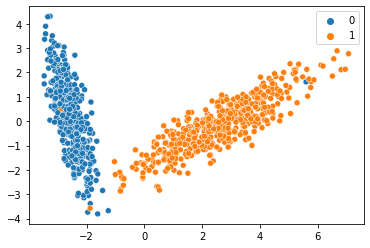

In [3]:
# генерируем выборку
features, targets = make_classification(
    n_samples=1000, n_features=INPUT_SIZE, n_classes=2, random_state=42, n_clusters_per_class=1, class_sep=2)

# понизим размерность для визуализации
# с помощью метода PCA
pca = PCA(n_components=2)
features_r = pca.fit(features).transform(features)

# визуализируем
ax = sns.scatterplot(x=features_r[:, 0], y=features_r[:, 1], hue=targets);

Выглядит неплохо. Разобьем выборки на тренировочную и тестовую, инициализируем Dataloaders.

In [4]:
# разобьем на тренировочную и тестовую выборки
train_x, test_x, train_y, test_y = train_test_split(
    features, targets, train_size=0.9, random_state=42, shuffle=True, stratify=targets)

# отмасштабируем данные
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x.shape, test_x.shape, train_y.shape, test_y.shape

((900, 32), (100, 32), (900,), (100,))

In [5]:
# инициализируем датасеты и даталоадеры
# тренировочная выборка
train_set = TensorDataset(
    torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# тестовая выборка
test_set = TensorDataset(
    torch.tensor(test_x, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Посмотрим, что получается

In [6]:
features, labels = next(iter(train_loader))
features.shape, labels.shape

(torch.Size([32, 32]), torch.Size([32]))

### Build the model

Соберем простую модель, состоящую из нескольких FC слоев.

In [114]:
class SimpleModel(nn.Module):
    def __init__(self, input_size: int = 32, hidden_size: int = 16, output_size: int = 1):
        super().__init__()       
        
        def _kaiming_normal(m: nn.Module):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                m.bias.data.fill_(0.)
                
        self.classifier = nn.Sequential(
            # первый слой
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            
            # второй слой
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            
            # третий слой
            nn.Linear(in_features=hidden_size, out_features=output_size),
        )
        self.apply(_kaiming_normal)

        
    def forward(self, features):
        outputs = self.classifier(features)
        return outputs

In [132]:
model = SimpleModel(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)

### Trainig loop

In [133]:
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s %(levelname)s:%(message)s")
logger = logging.getLogger(__name__)


class TrainModel:
    def __init__(self, model: nn.Module, ini_lr: Union[int, float] = 1e-3, logging_level: str = "INFO",
                 device: str = "cuda") -> None:
        # set logger level
        logger.setLevel(logging_level)
        
        self.device = device if torch.cuda.is_available() else "cpu"
        logger.info(f"Device: {self.device}")
        
        self.model = model
        model.to(self.device)
        
        logger.info("Optimizer initialization")
        self._optimizer = optim.Adam(params=self.model.parameters(), lr=ini_lr)
        
        # nn.BCEWithLogitsLoss = nn.Sigmoid + nn.BCELoss, but more stable (in accordance with the documentation)
        self._loss = nn.BCEWithLogitsLoss()
        self._criterion = Accuracy()
        self._scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
    
    def training_loop(self, train_loader: DataLoader, test_loader: DataLoader, epochs: int = 20):
        for epoch in range(epochs):
            # reset info about max memory allocated (for CUDA only)
            if self.device == "cuda":
                torch.cuda.reset_peak_memory_stats(device=self.device)
            
            logger.info(f"Epoch [{epoch + 1}/{epochs}]")
            running_loss_train, running_acc_train = self.train_nn(train_loader=train_loader)
            
            with torch.no_grad():
                running_loss_test, running_acc_test = self.eval_nn(test_loader=test_loader)
                
            curr_loss_train = np.mean(running_loss_train)
            curr_loss_test = np.mean(running_loss_test)
            curr_acc_train = np.mean(running_acc_train)
            curr_acc_test = np.mean(running_acc_test)
            
            logger.info("\tTrain:")
            logger.info("\t\tLoss: {:.4f}, Accuracy: {:.4f}".format(curr_loss_train, curr_acc_train))
            logger.info("\tTest:")
            logger.info("\t\tLoss: {:.4f}, Accuracy: {:.4f}".format(curr_loss_test, curr_acc_test))
            
            if self.device == "cuda":
                logger.info("\tCUDA max memory allocated: [{}/{}]".format(
                    torch.cuda.max_memory_allocated(device=self.device), torch.cuda.max_memory_reserved(device=self.device)))
            
            # clean up cache
            if self.device == "cuda":
                torch.cuda.empty_cache()
                gc.collect()
        return
    
    def train_nn(self, train_loader: DataLoader) -> Tuple[List, List]:
        running_loss = list()
        running_acc = list()
        
        self.model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            logger.debug(f"\t\tTrain step [{i + 1}]")
            inputs, labels = inputs.to(self.device), labels.reshape(-1, 1).to(self.device)
            
            # set gradients to zero
            self._optimizer.zero_grad()
            
            # forward pass and loss calculation with autocast
            # torch.autocast(device_type="cuda") is equivalent to torch.cuda.amp.autocast()
            # torch.autocast(device_type="cpu") is equivalent to torch.cpu.amp.autocast()     
            with torch.autocast(device_type=self.device):
                outputs = self.model(inputs)            
                loss = self._loss(outputs, labels)
            acc = self._criterion(outputs.cpu(), labels.cpu().to(torch.uint8))

            # backward pass
            self._scaler.scale(loss).backward()
            
            # update weights
            self._scaler.step(self._optimizer)
            self._scaler.update()
            
            # write results
            logger.debug("\t\tLoss: {:.4f}, Accuracy: {:.4f}".format(loss, acc))
            running_loss.append(loss.item())
            running_acc.append(acc.item())
        return running_loss, running_acc
    
    def eval_nn(self, test_loader: DataLoader) -> Tuple[List, List]:
        running_loss = list()
        running_acc = list()
        
        self.model.eval()
        for i, (inputs, labels) in enumerate(test_loader):
            logger.debug(f"\t\tEval step [{i + 1}]:")
            inputs, labels = inputs.to(self.device), labels.reshape(-1, 1).to(self.device)
            
            # forward pass and loss calculation
            outputs = self.model(inputs)
            loss = self._loss(outputs, labels)
            acc = self._criterion(outputs.cpu(), labels.cpu().to(torch.uint8))
            
            # write results
            logger.debug("\t\tLoss: {:.4f}, Accuracy: {:.4f}".format(loss, acc))
            running_loss.append(loss.item())
            running_acc.append(acc.item())
        return running_loss, running_acc

In [134]:
tm = TrainModel(model=model, device="cuda", logging_level="INFO")
tm.training_loop(train_loader=train_loader, test_loader=test_loader, epochs=20)

2022-11-04 12:38:31,687 INFO:Device: cuda
2022-11-04 12:38:32,067 INFO:Optimizer initialization
2022-11-04 12:38:32,069 INFO:Epoch [1/20]
2022-11-04 12:38:32,253 INFO:	Train:
2022-11-04 12:38:32,254 INFO:		Loss: 1.2668, Accuracy: 0.5119
2022-11-04 12:38:32,254 INFO:	Test:
2022-11-04 12:38:32,255 INFO:		Loss: 0.9170, Accuracy: 0.4531
2022-11-04 12:38:32,256 INFO:	CUDA max memory allocated: [37888/2097152]
2022-11-04 12:38:32,514 INFO:Epoch [2/20]
2022-11-04 12:38:32,723 INFO:	Train:
2022-11-04 12:38:32,723 INFO:		Loss: 0.8821, Accuracy: 0.5560
2022-11-04 12:38:32,724 INFO:	Test:
2022-11-04 12:38:32,725 INFO:		Loss: 0.7856, Accuracy: 0.5469
2022-11-04 12:38:32,725 INFO:	CUDA max memory allocated: [37888/2097152]
2022-11-04 12:38:32,980 INFO:Epoch [3/20]
2022-11-04 12:38:33,184 INFO:	Train:
2022-11-04 12:38:33,185 INFO:		Loss: 0.7105, Accuracy: 0.6390
2022-11-04 12:38:33,187 INFO:	Test:
2022-11-04 12:38:33,187 INFO:		Loss: 0.6713, Accuracy: 0.6016
2022-11-04 12:38:33,188 INFO:	CUDA max me

Обратите внимание, что с `autocast` используется `BCEWithLogitsLoss`. Это требование PyTorch, в противном случае он выкидывает ошибку:

```text
torch.nn.functional.binary_cross_entropy and torch.nn.BCELoss are unsafe to autocast. Many models use a sigmoid layer right before the binary cross entropy layer. In this case, combine the two layers using torch.nn.functional.binary_cross_entropy_with_logits or torch.nn.BCEWithLogitsLoss. binary_cross_entropy_with_logits and BCEWithLogits are safe to autocast.
```

По сути своей `BCEWithLogitsLoss` $\equiv$ `Sigmoid` + `BCELoss`. Поэтому используя `BCEWithLogitsLoss` на последнем слое сети не нужно добавлять активацию `Sigmoid`, чтобы привести выход из сети к интервалу $\left[ 0, 1 \right]$.

Доказательство эквивалентности `BCEWithLogitsLoss` $\equiv$ `Sigmoid` + `BCELoss` приведено ниже

In [79]:
import scipy.stats as stats


# генерируем outputs (из стандартного нормального распределения) и labels (распределение Бернули)
outputs = torch.randn((100, ))
targets = torch.from_numpy(stats.bernoulli.rvs(0.3, size=100)).to(torch.float32)

loss = nn.BCELoss()(nn.Sigmoid()(outputs), targets).item()
loss_logits = nn.BCEWithLogitsLoss()(outputs, targets).item()

print("Sigmoid + BCELoss:\t{:.4f}".format(loss))
print("BCEWithLogitsLoss:\t{:.4f}".format(loss_logits))

Sigmoid + BCELoss:	0.8747
BCEWithLogitsLoss:	0.8747


Как видно, мы получили идентичные результаты.